In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
from datetime import datetime, timedelta
import sys
from scipy.optimize import curve_fit
import random

#import the folder that has the analysis level class
sys.path.append("../CombinedData/")
sys.path.append("../AnalysisTools/")
import Dataset
import AnalysisTools


In [3]:
common = "/p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/"
#common = "../../data/" 
topdirs = {5:"{}Run5/".format(common), 6:"{}Run6/".format(common), 7:"{}Run7/".format(common), 8:"{}Run8/".format(common), 9:"{}Run9/".format(common)}
configs = {5:"../configs/run5_config.yaml", 6:"../configs/run6_config.yaml", 7:"../configs/run7_config.yaml", 8:"../configs/run8_config.yaml", 9:"../configs/run9_config.yaml"}
titles = {5:"SS uncoated", 6:"Refill of SS uncoated", 7:"Al-MgF2 (50nm)", 8:"Al-Pt (50nm)", 9:"Al-MgF2 (20nm)"}
red_file_name = "combined_reduced.p"
#analysis tools objects, unloaded data
anas = {}
for n in topdirs:
    anas[n] = AnalysisTools.AnalysisTools(topdirs[n]+red_file_name, configs[n], title=titles[n], ramp_topdir=topdirs[n])


/g/g15/angelico/ad2-data-processing/notebooks/../AnalysisTools/AnalysisTools.py:127: UserWarning: genfromtxt: Empty input file: "/p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/Run8/ds03/g_events.txt"
  d = np.genfromtxt(os.path.join(root, self.config["g_events_name"]), delimiter=',', dtype=float)


In [4]:
#load data into mem if you want
for n, ana in anas.items():
    ana.load_dataframe()

In [34]:
ana = anas[6]
all_light = ana.get_light_triggers()
print("Total light triggers: {:d}".format(len(all_light.index)))
tsep = 10 #seconds from any charge signals
cosmic_light = ana.get_cosmic_triggers(tsep, N=1000)
print("Total cosmic triggers: {:d}".format(len(cosmic_light.index)))

Total light triggers: 42187
On event 0 of 1000
On event 0 of 1000
On event 100 of 1000
On event 200 of 1000
On event 200 of 1000
On event 200 of 1000
On event 300 of 1000
On event 400 of 1000
On event 500 of 1000
On event 600 of 1000
On event 600 of 1000
On event 600 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 800 of 1000
On event 800 of 1000
On event 800 of 1000
On event 900 of 1000
Total cosmic triggers: 1000


In [35]:
#get waveforms for these events, channels 0 and 1 are PMTs
events = ana.get_waveforms_from_df(cosmic_light, [0, 1])

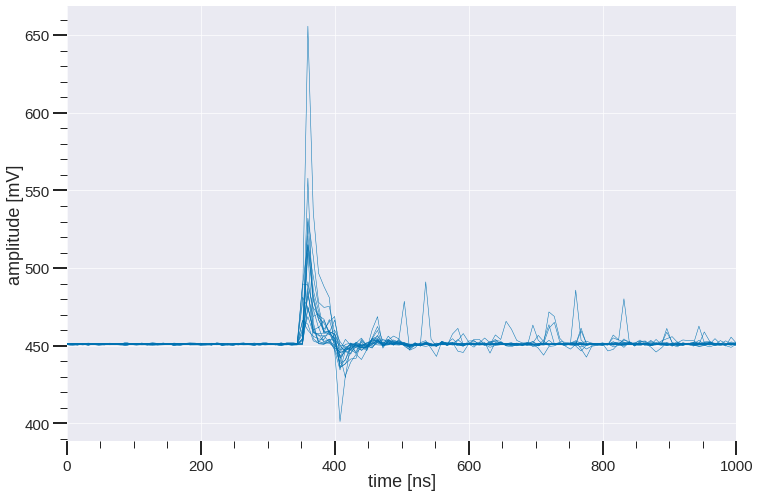

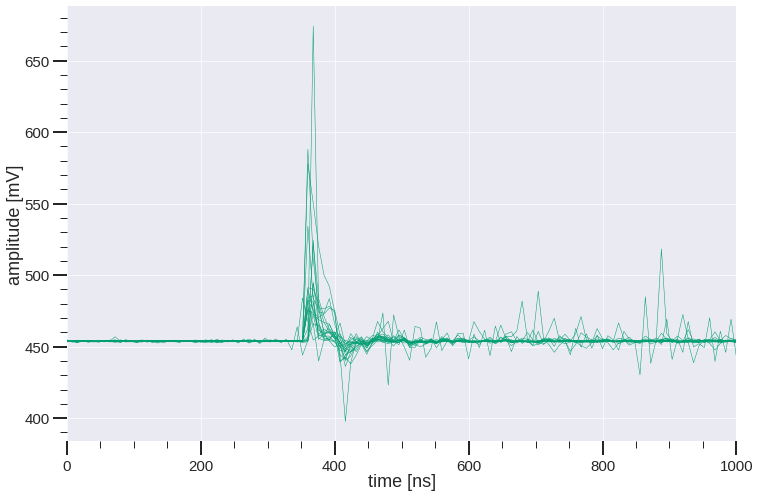

In [16]:
#overlay plot
for ch in [0,1]:
    N_overlay = 20
    evs = random.sample(events[ch], k=N_overlay)
    dT = 1000.0/125 #ns
    fig, ax = plt.subplots()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for e in evs:
        times = np.arange(0, len(e["Data"])*dT, dT)
        ax.plot(times, e["Data"], color=colors[ch], linewidth=0.5)
    ax.set_xlim([0, 1000])
    ax.set_xlabel("time [ns]")
    ax.set_ylabel("amplitude [mV]")
    plt.show()
    

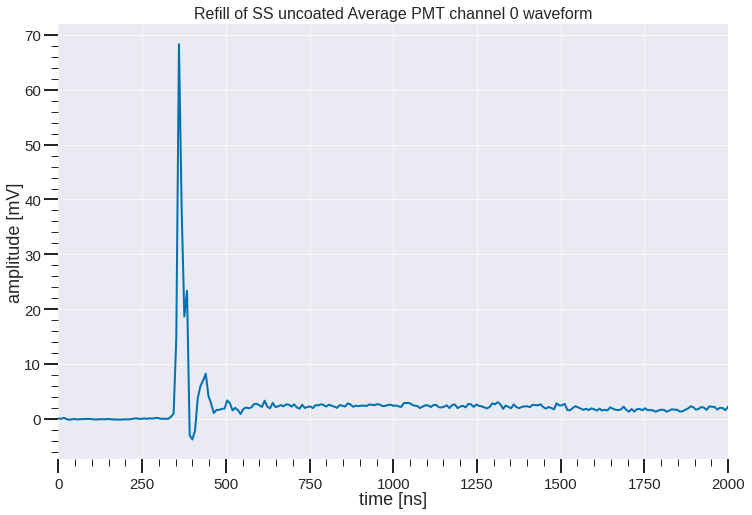

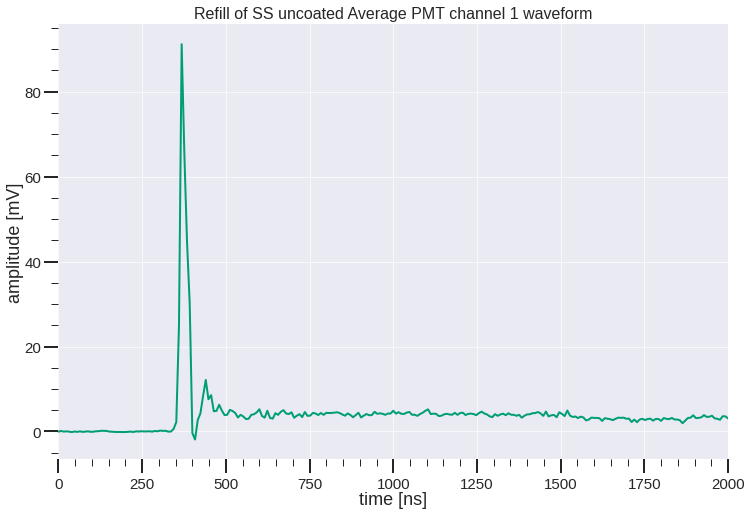

In [36]:
#average waveform plot
bl_wind = ana.config["struck_reduction"]["baseline_window"]

for ch in [0,1]:
    avg_wave = []
    #N_overlay = 200
    #evs = random.sample(events[ch], k=N_overlay)
    evs = events[ch]
    wave_counter = 0
    for e in evs:
        if(len(avg_wave) == 0):
            v = np.array(e["Data"])
            v = v - np.mean(v[bl_wind[0]:bl_wind[1]])
            avg_wave = v
            wave_counter += 1
        elif(len(avg_wave) != len(e["Data"])):
            print("Length mismatch!")
        else:
            v = np.array(e["Data"])
            v = v - np.mean(v[bl_wind[0]:bl_wind[1]])
            avg_wave = avg_wave + v
            wave_counter += 1
            
    avg_wave = avg_wave/wave_counter
    fig, ax = plt.subplots()
    dT = 1000.0/125 #ns
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    times = np.arange(0, len(avg_wave)*dT, dT)
    ax.plot(times, avg_wave, color=colors[ch])
    ax.set_xlim([0, 2000])
    ax.set_xlabel("time [ns]")
    ax.set_ylabel("amplitude [mV]")
    ax.set_title(ana.title + " Average PMT channel {:d} waveform".format(ch))
    plt.show()
    

In [55]:
#Get coincidence with charge events that are negative polar
ana = anas[9]
df = ana.df
thr_mask = (df["ch3 amp"] < -2)


coinc_sec = 0
coinc_ns = 0.4e9 #nanoseconds
charge_ch = 3
coinc_events = ana.get_coincidence(df[thr_mask], charge_ch, coinc_sec, coinc_ns)

In [56]:
#flatten the coinc events into a single DF
coinc_df = pd.concat(coinc_events, ignore_index=True)
#get waveforms for these events, channels 0 and 1 are PMTs
events = ana.get_waveforms_from_df(coinc_df, [0, 1])

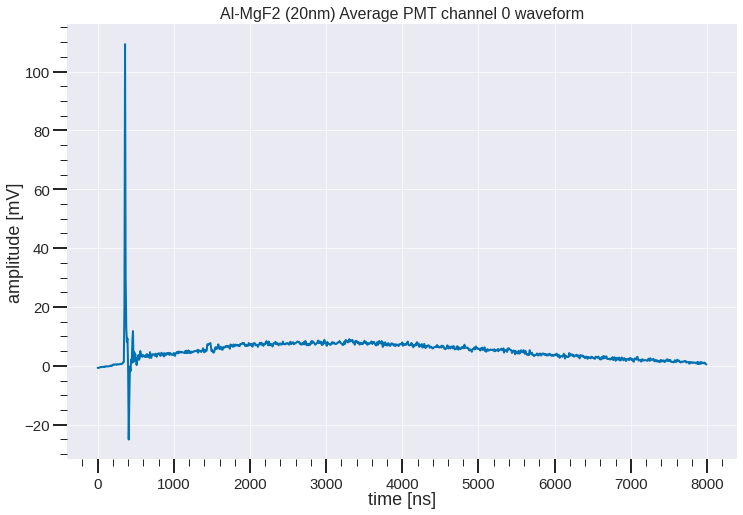

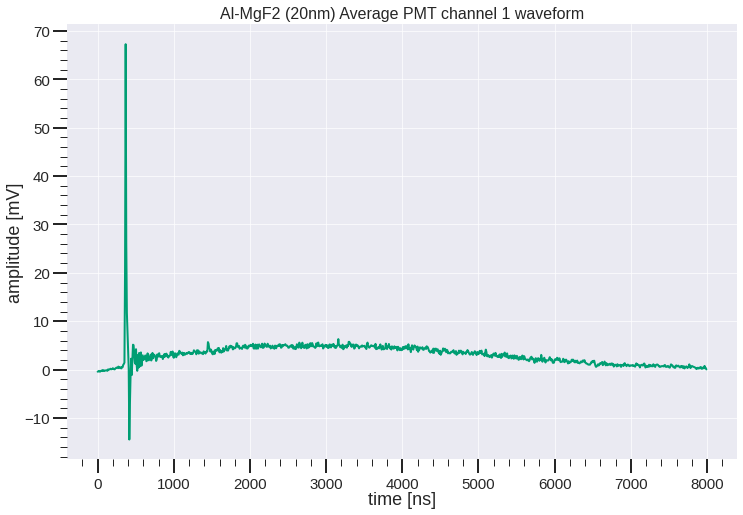

In [63]:
#average waveform plot
bl_wind = ana.config["struck_reduction"]["baseline_window"]

for ch in [0,1]:
    avg_wave = []
    #N_overlay = 200
    #evs = random.sample(events[ch], k=N_overlay)
    evs = events[ch]
    wave_counter = 0
    for e in evs:
        if(len(avg_wave) == 0):
            v = np.array(e["Data"])
            v = v - np.mean(v[bl_wind[0]:bl_wind[1]])
            avg_wave = v
            wave_counter += 1
        elif(len(avg_wave) != len(e["Data"])):
            print("Length mismatch!")
        else:
            v = np.array(e["Data"])
            v = v - np.mean(v[bl_wind[0]:bl_wind[1]])
            avg_wave = avg_wave + v
            wave_counter += 1
            
    avg_wave = avg_wave/wave_counter
    fig, ax = plt.subplots()
    dT = 1000.0/125 #ns
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    times = np.arange(0, len(avg_wave)*dT, dT)
    ax.plot(times, avg_wave, color=colors[ch])
    #ax.set_xlim([0, 2000])
    ax.set_xlabel("time [ns]")
    ax.set_ylabel("amplitude [mV]")
    ax.set_title(ana.title + " Average PMT channel {:d} waveform".format(ch))
    plt.show()
    

950


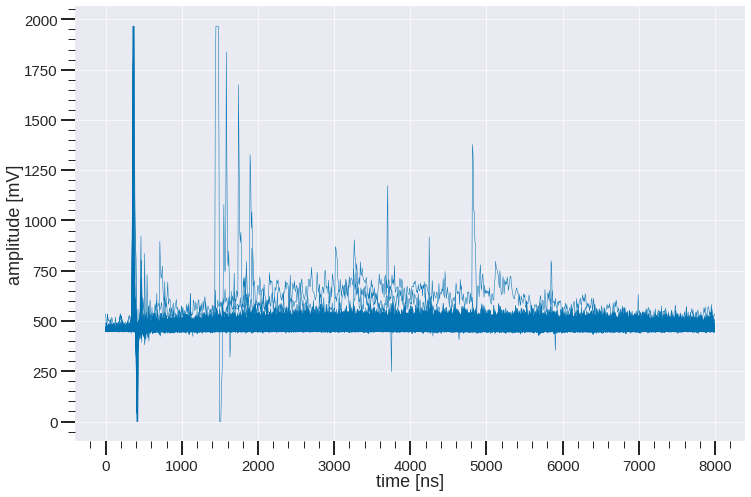

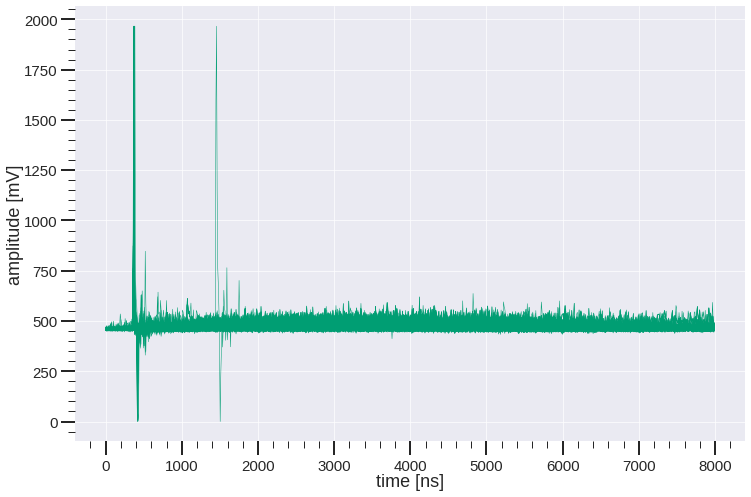

In [62]:
#overlay plot
for ch in [0,1]:
    N_overlay = 900
    evs = random.sample(events[ch], k=N_overlay)
    dT = 1000.0/125 #ns
    fig, ax = plt.subplots()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for e in evs:
        times = np.arange(0, len(e["Data"])*dT, dT)
        ax.plot(times, e["Data"], color=colors[ch], linewidth=0.5)
    #ax.set_xlim([0, 1000])
    ax.set_xlabel("time [ns]")
    ax.set_ylabel("amplitude [mV]")
    plt.show()
    

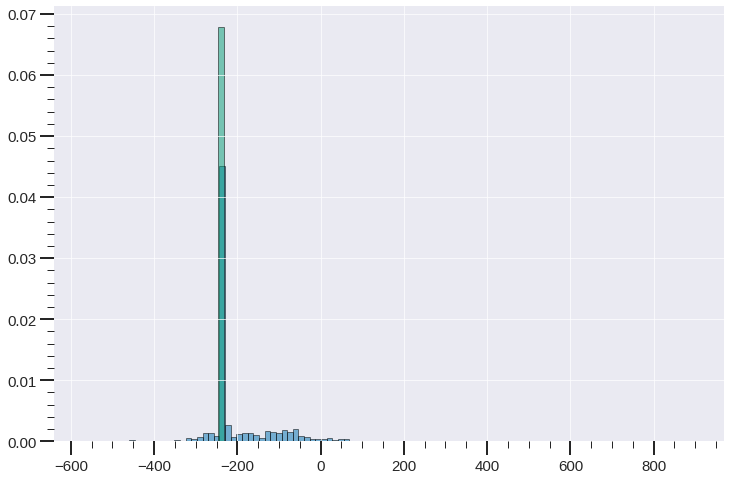

In [79]:
fig, ax = plt.subplots()
ax.hist(np.array(coinc_df["ch0 afterpulse integral"]) - np.array(coinc_df["ch0 baseline"])*8, bins=100, alpha=0.5, density=1)
ax.hist(np.array(ana.df["ch0 afterpulse integral"]) - np.array(ana.df["ch0 baseline"])*8, bins=100, alpha=0.5, density=1)
plt.show()